In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cvxpy as cp

from manipulation.manipulation import Manipulation
import pickle, os

In [2]:
#load train/test data
prob = Manipulation() #use default config, pass different config file oth.
config_fn = './manipulation/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/manipulation/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
train_file.close()

test_file = open(dataset_fn+'/test.p','rb')
test_data = pickle.load(test_file)
p_test, as_test, fs_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = len(c_test)

# test MLOPT solver

In [3]:
from solvers.mlopt import MLOPT

system = 'manipulation'
prob_features = ['w', 'mu']
mlopt_obj = MLOPT(system, prob, prob_features)

n_features = 13
mlopt_obj.construct_strategies(n_features, train_data)
print(mlopt_obj.n_strategies)

12


In [4]:
mlopt_obj.setup_network()

fn_saved = 'models/mlopt_manipulation_20200710_1158.pt'
fn_saved = 'models/mlopt_manipulation_20210119_0636.pt'
mlopt_obj.load_network(fn_saved)

mlopt_obj.model

Loading presaved classifier model from models/mlopt_manipulation_20210119_0636.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=12, bias=True)
  )
)

In [28]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 1000
mlopt_obj.training_params['BATCH_SIZE'] = 32
mlopt_obj.train(verbose=False)
print(mlopt_obj.model_fn)

Saved model at /home/acauligi/cs_234/project/mlopt-micp/mlopt_manipulation_20210119_0636.pt
Done training
/home/acauligi/cs_234/project/mlopt-micp/mlopt_manipulation_20210119_0636.pt


In [7]:
n_succ = 0
count = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 100 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = mlopt_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_mlopt += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('failed')
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)
mlopt_percentage

0 / 500


100.0

# test Regression solver

In [5]:
from solvers.regression import Regression

system = 'manipulation'
prob_features = ['w', 'mu']
reg_obj = Regression(system, prob, prob_features)

n_features = 13
reg_obj.construct_strategies(n_features, train_data)

In [6]:
reg_obj.setup_network()

fn_saved = 'models/regression_manipulation_20210119_1057.pt'
reg_obj.load_network(fn_saved)

reg_obj.model

Loading presaved regression model from models/regression_manipulation_20210119_1057.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=13, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=30, bias=True)
  )
)

In [40]:
reg_obj.training_params['TRAINING_ITERATIONS'] = 1000
reg_obj.train(verbose=False)
print(reg_obj.model_fn)

/home/acauligi/cs_234/project/mlopt-micp/regression_manipulation_20210119_1057.pt
Saved model at /home/acauligi/cs_234/project/mlopt-micp/regression_manipulation_20210119_1057.pt
Done training
/home/acauligi/cs_234/project/mlopt-micp/regression_manipulation_20210119_1057.pt


In [8]:
n_succ = 0
count = 0

costs_reg = []
total_time_reg = []
num_solves_reg = []

cost_ratios_reg = []

for ii in range(n_test):
    if ii % 100 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    p_test = test_data[0]
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, optvals = reg_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_reg += [cost]
            total_time_reg += [total_time]
            num_solves_reg += [1]

            true_cost = c_test[ii]
            cost_ratios_reg += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        continue

costs_reg = np.array(costs_reg)
cost_ratios_reg = np.array(cost_ratios_reg)
total_time_reg = np.array(total_time_reg)
num_solves_reg = np.array(num_solves_reg, dtype=int)

reg_percentage = 100 * float(n_succ) / float(count)
reg_percentage

100.0

# Martius & Zhu (2019)

In [9]:
from solvers.knn import KNN

In [10]:
system = 'manipulation'
prob_features = ['w', 'mu']

knn_obj = KNN(system, prob, prob_features, knn=mlopt_obj.n_evals)

n_features = 13
knn_obj.train(n_features, train_data)

In [11]:
n_succ = 0
count = 0

costs_knn = []
total_time_knn = []
num_solves_knn = []

cost_ratios_knn = []

for ii in range(n_test):
    if ii % 100 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = knn_obj.forward(prob_params, solver=cp.MOSEK)

        count += 1
        if prob_success:
            n_succ += 1
            costs_knn += [cost]
            total_time_knn += [total_time]
            num_solves_knn += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_knn += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_knn = np.array(costs_knn)
cost_ratios_knn = np.array(cost_ratios_knn)
total_time_knn = np.array(total_time_knn)
num_solves_knn = np.array(num_solves_knn, dtype=int)

knn_percentage = 100 * float(n_succ) / float(count)

0 / 500


# Mosek

### Make sure set value for max number of feasible solutions for solver

In [27]:
print('Cutoff time for Mosek: {}'.format(np.max(total_time_mlopt)))

Cutoff time for Mosek: 0.01743626594543457


In [173]:
solver = cp.MOSEK

n_succ = 0
count = 0

costs_sol = []
cost_ratios_sol = []
total_time_sol = []

for ii in range(n_test):
    count += 1
    if ii % 100 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, optvals = prob.solve_micp(prob_params, solver=solver)

        if prob_success:
            n_succ += 1
            costs_sol += [cost]

            true_cost = c_test[ii]
            cost_ratios_sol += [cost / true_cost]
            total_time_sol += [total_time]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_sol = np.array(costs_sol)
cost_ratios_sol = np.array(cost_ratios_sol)
total_time_sol = np.array(total_time_sol)

sol_percentage = 100 * float(n_succ) / float(count)
sol_percentage

0 / 500
100 / 500
200 / 500
300 / 500
400 / 500


100.0

# Results

In [10]:
import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd
import h5py
import matplotlib

flierprops = {'alpha':0.2}

params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
              'font.size': 90, # was 12 and before 10
              'legend.fontsize': 12, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
              'text.usetex': True,
              'font.family': 'serif',
              'font.sans-serif':['Helvetica Neue']
    }

params = {
#     'backend': 'ps',
#               'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
#               'font.size': 12, # was 12 and before 10
              'legend.fontsize': 26, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
#               'text.usetex': True,
#               'font.family': 'serif',
#               'font.sans-serif':['Helvetica Neue']
    }

sns.set(font_scale=2.)
matplotlib.rcParams.update(params)

In [181]:
percentage_dict = {'mosek':sol_percentage, 'coco':mlopt_percentage, 'regressor':reg_percentage, 'knn':knn_percentage}
num_solves_dict = {'coco':num_solves_mlopt, 'regressor':num_solves_reg, 'knn':num_solves_knn}
total_time_dict = {'mosek':total_time_sol, 'coco':total_time_mlopt, 'regressor':total_time_reg, 'knn':total_time_knn}
cost_ratios_dict = {'mosek':cost_ratios_sol, 'coco':cost_ratios_mlopt, 'regressor':cost_ratios_reg, 'knn':cost_ratios_knn}

In [258]:
# hf = h5py.File('manipulation_dev.h5', 'w')

# hf.create_dataset('percentage', data=np.expand_dims(np.asarray([sol_percentage, mlopt_percentage, reg_percentage, knn_percentage]), axis=1))

# num_solves_grp = hf.create_group('num_solves')
# num_solves_grp.create_dataset('num_solves_mlopt', data=np.expand_dims(num_solves_mlopt, axis=1))
# num_solves_grp.create_dataset('num_solves_reg', data=np.expand_dims(num_solves_reg, axis=1))
# num_solves_grp.create_dataset('num_solves_knn', data=np.expand_dims(num_solves_knn, axis=1))

# total_time_grp = hf.create_group('total_time')
# total_time_grp.create_dataset('total_time_sol', data=np.expand_dims(total_time_sol, axis=1))
# total_time_grp.create_dataset('total_time_mlopt', data=np.expand_dims(total_time_mlopt, axis=1))
# total_time_grp.create_dataset('total_time_reg', data=np.expand_dims(total_time_reg, axis=1))
# total_time_grp.create_dataset('total_time_knn', data=np.expand_dims(total_time_knn, axis=1))

# cost_ratios_grp = hf.create_group('cost_ratios')
# cost_ratios_grp.create_dataset('cost_ratios_sol', data=np.expand_dims(cost_ratios_sol, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_mlopt', data=np.expand_dims(cost_ratios_mlopt, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_reg', data=np.expand_dims(cost_ratios_reg, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_knn', data=np.expand_dims(cost_ratios_knn, axis=1))

# hf.close()

In [4]:
hf = h5py.File('manipulation_dev.h5', 'r')

num_solves_grp = hf.get('num_solves')
num_solves_mlopt = np.squeeze(np.array(num_solves_grp.get('num_solves_mlopt')))
num_solves_reg = np.squeeze(np.array(num_solves_grp.get('num_solves_reg')))
num_solves_knn = np.squeeze(np.array(num_solves_grp.get('num_solves_knn')))

total_time_grp = hf.get('total_time')
total_time_sol = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_sol'))))
total_time_mlopt = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_mlopt'))))
total_time_reg = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_reg'))))
total_time_knn = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_knn'))))

cost_ratios_grp = hf.get('cost_ratios')
cost_ratios_sol = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_sol')))
cost_ratios_mlopt = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_mlopt')))
cost_ratios_reg = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_reg')))
cost_ratios_knn = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_knn')))

sol_percentage, mlopt_percentage, reg_percentage, knn_percentage = np.ndarray.tolist(np.squeeze(np.array(hf.get('percentage'))))

hf.close()

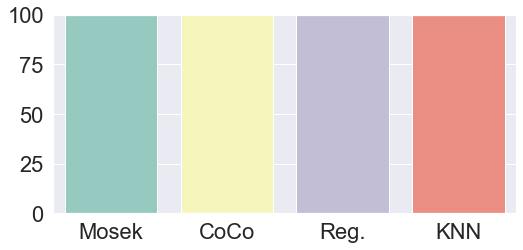

In [11]:
results = {'Mosek':[sol_percentage], 'CoCo':[mlopt_percentage], 'Reg.':[reg_percentage], 'KNN':[knn_percentage]}
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.ylim(0,100)
plt.tight_layout()

ax1 = sns.barplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")
ax1.set(xlabel="", ylabel="")

figure = ax1.get_figure()
plt.savefig("manipulation_percent_success.png", bbox_inches='tight')

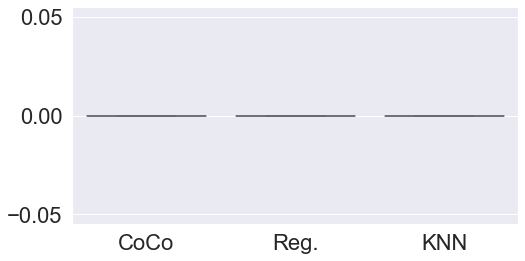

In [12]:
results = {}
results['Policy'] = ['CoCo']*len(num_solves_mlopt) + ['Reg.']*len(num_solves_reg) + ['KNN']*len(num_solves_knn)
results['Solves'] = np.hstack((np.log10(num_solves_mlopt), np.log10(num_solves_reg), np.log10(num_solves_knn)))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.tight_layout()

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(SOCPs Solved)")
ax1.set(xlabel="", ylabel="")

figure = ax1.get_figure()
figure.savefig("manipulation_solved.png", bbox_inches='tight')

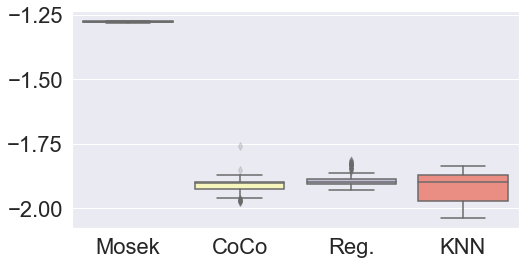

In [13]:
results = {}
results['Policy'] = ['Mosek']*len(total_time_sol) +  ['CoCo']*len(total_time_mlopt) + ['Reg.']*len(total_time_reg) + ['KNN']*len(total_time_knn)
results['Time'] = np.hstack((np.log10(total_time_sol), np.log10(total_time_mlopt), np.log10(total_time_reg), np.log10(total_time_knn)))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.tight_layout()

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(Time) [s]")
ax1.set(xlabel="", ylabel="")

figure = ax1.get_figure()
figure.savefig("manipulation_time.png", bbox_inches='tight')

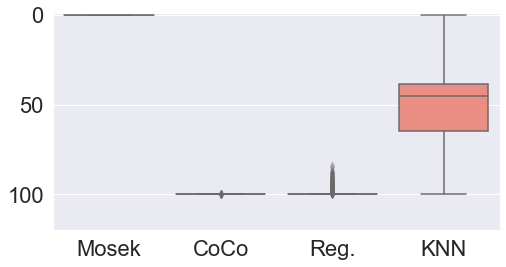

In [14]:
results = {}
results['Policy'] = ['Mosek']*len(cost_ratios_sol) + ['CoCo']*len(cost_ratios_mlopt) + ['Reg.']*len(cost_ratios_reg) + ['KNN']*len(cost_ratios_knn)
results['Costs'] = np.hstack((100*cost_ratios_sol, 100*cost_ratios_mlopt, 100*cost_ratios_reg, 100*cost_ratios_knn))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.tight_layout()

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="Relative Cost [%]", ylim=(-1,120))
ax1.set(xlabel="", ylabel="")
ax1.invert_yaxis()

figure = ax1.get_figure()
figure.savefig("manipulation_cost.png", bbox_inches='tight')

In [10]:
knn_percentage

100.0